In [69]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from scipy.interpolate import interp1d
from scipy.spatial.distance import directed_hausdorff
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
# import scienceplots
# plt.style.use('science')

class DifferentialDriveRobot:
    def __init__(self, R, L):
        self.R = R  # Raio da roda
        self.L = L  # Distância entre as rodas
        
        # Estados iniciais
        self.x = 0
        self.y = 0
        self.theta = 0

    def update(self, v_R, v_L, dt):
        v = (self.R / 2) * (v_R + v_L)
        omega = (self.R / self.L) * (v_R - v_L)
        
        self.x += v * np.cos(self.theta) * dt
        self.y += v * np.sin(self.theta) * dt
        self.theta += omega * dt


class MPCController:
    """
    ### MPC Controller Class \n
    :param DifferentialDriveRobot robot: A robot model
    :param int N: Prediction Horizon
    :param float Q: Penalty for tracking error
    :param float R: Penalty for control effort
    :param float dt: Time interval
    :param max_margin: A margin of robot maximum offset
    """
    def __init__(self, robot, N, Q, R, dt, max_margin):
        self.robot = robot
        self.N = N  
        self.Q = Q  
        self.R = R  
        self.dt = dt
        self.max_margin = max_margin  # Distância máxima permitida da trajetória de referência

    def solve(self, x_ref, y_ref, disable_constrain = False):
        model = pyo.ConcreteModel()

        model.N = self.N
        model.dt = self.dt
        model.Q = self.Q
        model.R = self.R
        model.x_ref = x_ref
        model.y_ref = y_ref

        # Variáveis de otimização
        model.v_R = pyo.Var(range(model.N), domain=pyo.Reals)
        model.v_L = pyo.Var(range(model.N), domain=pyo.Reals)

        # Estados
        model.x = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.y = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)
        model.theta = pyo.Var(range(model.N+1), domain=pyo.Reals, initialize=0)

        # Estados iniciais
        model.x[0].fix(self.robot.x)
        model.y[0].fix(self.robot.y)
        model.theta[0].fix(self.robot.theta)

        # Variável auxiliar para a Distância de Hausdorff
        model.hausdorff_dist = pyo.Var()

        # Função custo
        def objective_rule(model):
            cost = 0
            for t in range(1, model.N):
                cost += model.Q * ((model.x[t] - model.x_ref[t])**2 + (model.y[t] - model.y_ref[t])**2)
                # cost += model.R * (model.v_R[t]**2 + model.v_L[t]**2)
                # cost += model.R * ((model.v_R[t] - model.v_L[t])**2)
                cost += model.R * ((model.v_R[t] - model.v_R[t-1])**2 + (model.v_L[t] - model.v_L[t-1])**2)
   
            return cost
        
        model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

        # Restrições de dinâmica
        model.dynamics = pyo.ConstraintList()
        for t in range(model.N):
            v = (self.robot.R / 2) * (model.v_R[t] + model.v_L[t])
            omega = (self.robot.R / self.robot.L) * (model.v_R[t] - model.v_L[t])
            model.dynamics.add(model.x[t+1] == model.x[t] + v * pyo.cos(model.theta[t]) * model.dt)
            model.dynamics.add(model.y[t+1] == model.y[t] + v * pyo.sin(model.theta[t]) * model.dt)
            model.dynamics.add(model.theta[t+1] == model.theta[t] + omega * model.dt)

        if not disable_constrain:
            # Limites das variáveis de controle
            def control_limits_rule_R(model, t):
                return (-1, model.v_R[t], 1)
            
            def control_limits_rule_L(model, t):
                return (-1, model.v_L[t], 1)

            model.control_limits_R = pyo.Constraint(range(model.N), rule=control_limits_rule_R)
            model.control_limits_L = pyo.Constraint(range(model.N), rule=control_limits_rule_L)

            # Hausdorff_constraint of margin
            # def hausdorff_constraint(model):
            #     # Listas de pontos da trajetória atual e da referência
            #     traj_pred = [(model.x[i].value, model.y[i].value) for i in range(self.N)]
            #     traj_ref = [(model.x_ref[i], model.y_ref[i]) for i in range(self.N)]

            #     # Calcula a Distância de Hausdorff em ambas direções
            #     hd_dist_1 = directed_hausdorff(traj_pred, traj_ref)[0]
            #     hd_dist_2 = directed_hausdorff(traj_ref, traj_pred)[0]
                
            #     # Define a Distância de Hausdorff como o máximo entre as duas direções
            #     model.hausdorff_dist.set_value(max(hd_dist_1, hd_dist_2))

            #     # Restrições para garantir que a Distância de Hausdorff fique dentro do limite
            #     return model.hausdorff_dist <= self.max_margin

            # Adiciona a restrição de Hausdorff ao modelo
            # model.hausdorff_constraint = pyo.Constraint(rule=hausdorff_constraint)

        # Solver
        solver = SolverFactory('ipopt')
        result = solver.solve(model, tee=False)

        # Extrair os valores de controle resultantes
        out_X = [model.x[i]() for i in range(self.N)]
        out_Y = [model.y[i]() for i in range(self.N)]

        out_v_R = [model.v_R[i]() for i in range(self.N)]
        out_v_L = [model.v_L[i]() for i in range(self.N)]
        print('out_X', out_X)
        print('out_Y', out_Y)
        print('out_v_R', out_v_R)
        print('out_v_L', out_v_L)
        return model.v_R[0].value, model.v_L[0].value, [out_X, out_Y], [out_v_R, out_v_L]

# Parâmetros do robô
R = 0.1  # Raio da roda em metros
L = 0.5  # Distância entre as rodas em metros

# Criar instância do robô diferencial
robot = DifferentialDriveRobot(R, L)

# Criar instância do controlador MPC
predict_horizon = 10
margin = 0.1  # Distância da margem em metros
delta_time = 1
mpc = MPCController(robot, N=predict_horizon, Q=120, R=0.005, dt=delta_time, max_margin=margin)
plt_path = './assets/tcc/out/'
# Referência de trajetória
in_points = [[-0.09150369689456136, 0.48914467381475923], [-0.09846197449972373, 0.5594131906773301], [-0.10708867633569592, 0.6468840483426161], [-0.11807990084029595, 0.7587300914046574], [-0.13122400333321313, 0.9066888477317598], [-0.15099370681792523, 1.111769544992076]]

Xc = []
Yc = []
for point in in_points:
    Xc.append(point[1])
    Yc.append(point[0])

print('Xc: ', Xc)
print('Yc: ', Yc)


cs = CubicSpline([0] + Xc, [0] + Yc)
x_smooth = np.linspace(0, Xc[-1], num=30)
y_smooth = cs(x_smooth)



Xc:  [0.48914467381475923, 0.5594131906773301, 0.6468840483426161, 0.7587300914046574, 0.9066888477317598, 1.111769544992076]
Yc:  [-0.09150369689456136, -0.09846197449972373, -0.10708867633569592, -0.11807990084029595, -0.13122400333321313, -0.15099370681792523]


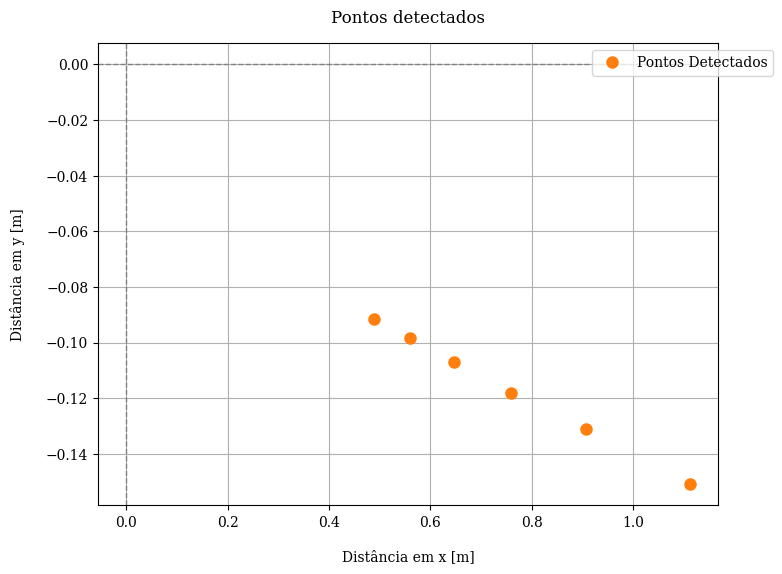

<Figure size 640x480 with 0 Axes>

In [70]:
# ------------------------------------------------------
#  Plot pontos detectados

plt.figure(figsize=(8, 6))
plt.plot([], [], 'o-', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados', markersize=8)

plt.rcParams['font.family'] = 'serif'

plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)

plt.title('Pontos detectados', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'detected_points_plot')
plt.show()
plt.clf()

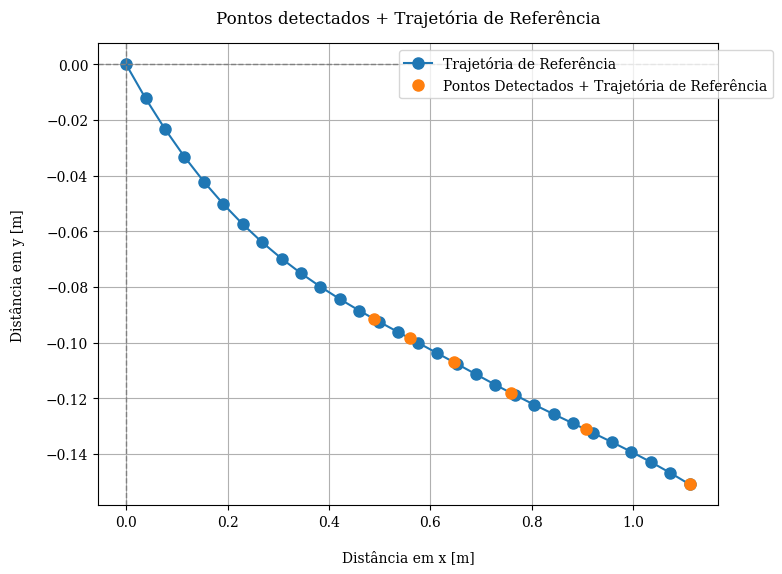

<Figure size 640x480 with 0 Axes>

In [71]:
# ------------------------------------------------------
#  Plot pontos detectados + Trajetória de Referência
plt.figure(figsize=(8, 6))
plt.plot(x_smooth, y_smooth, 'o-', label='Trajetória de Referência', markersize=8)
plt.plot(Xc, Yc, 'o', label='Pontos Detectados + Trajetória de Referência', markersize=8)

plt.rcParams['font.family'] = 'serif'
# Adicionando linhas verticais e horizontais passando pela origem (0, 0)
plt.axhline(0, color='gray', linewidth=1, linestyle='--')  # Linha horizontal
plt.axvline(0, color='gray', linewidth=1, linestyle='--')  # Linha vertical
plt.xlabel('Distância em x [m]', labelpad=15)
plt.ylabel('Distância em y [m]', labelpad=15)
# plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.title('Pontos detectados + Trajetória de Referência', pad=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), borderaxespad=0.5)

plt.grid(True)
plt.savefig(plt_path + 'trajectory')
plt.show()
plt.clf()

out_X [0, 0.03624826651400242, 0.07902893590219166, 0.1153356192080393, 0.15298919243795178, 0.19151535129582012, 0.22999801524676192, 0.2683838582670558, 0.30671392542637516, 0.3450271896446724]
out_Y [0, -9.4039548065783e-38, -0.016725865592753866, -0.032019930955430154, -0.04314103841105144, -0.051015748145618274, -0.057583918814435205, -0.06378273319917264, -0.06966721550082551, -0.07513396833548891]
out_v_R [-0.569256980273838, 0.39436261176535764, 0.6727119709277808, 0.60653201683377, 0.47465738686851155, 0.41275390600337736, 0.4082634001869699, 0.41429883648442395, 0.41352062996993705, 0.41352062996993705]
out_v_L [1.2942223105538864, 0.5243191074660863, 0.115217895991974, 0.17869931418033963, 0.31179692706085815, 0.3680293649997352, 0.3693993144020906, 0.36128382974694484, 0.360505623232458, 0.360505623232458]


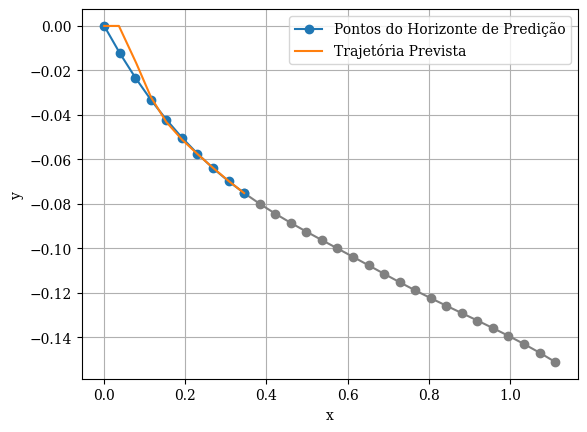

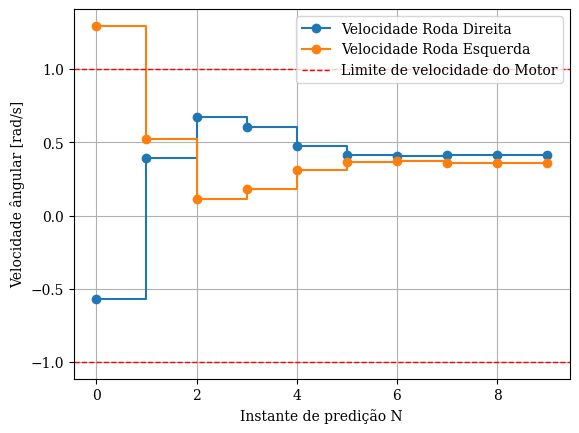

<Figure size 640x480 with 0 Axes>

In [72]:

# # Trajetória interpolada
x_ref = x_smooth
y_ref = y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []

v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon], disable_constrain=True)
v_out.append((v_R, v_L))
robot.update(v_R, v_L, dt)
x_traj.append(robot.x)
y_traj.append(robot.y)

# Plotar trajetória 
plt.plot(x_ref[predict_horizon - 1:], y_ref[predict_horizon - 1:], 'o-',color='grey')
plt.plot(x_ref[0:predict_horizon], y_ref[0:predict_horizon], 'o-', label='Pontos do Horizonte de Predição')
plt.plot(out_x, out_y, '-', label='Trajetória Prevista')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_predicted')
plt.show()
plt.clf() 

# Plotar Velocidade
plt.step(range(len(out_v_R)), out_v_R, 'o-', where='post', label='Velocidade Roda Direita')
plt.step(range(len(out_v_L)), out_v_L, 'o-', where='post', label='Velocidade Roda Esquerda')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('Instante de predição N')
plt.ylabel('Velocidade ângular [rad/s]')
plt.axhline(1, color='red', linewidth=1, linestyle='--', label='Limite de velocidade do Motor')  # Linha horizontal
plt.axhline(-1, color='red', linewidth=1, linestyle='--')  # Linha horizontal
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_velocity')
plt.show()
plt.clf() 


out_X [0.03624826651400242, 0.042487264144500804, 0.0782002544000744, 0.11500070600355448, 0.1531379743727257, 0.19160947685477334, 0.2300263311962929, 0.2683789868517945, 0.3067031083374695, 0.34502906169201975]
out_Y [0.0, -0.00243924738193917, -0.0191711005941711, -0.03292695583021642, -0.04288061017902794, -0.05058189323930563, -0.057414004450161836, -0.06381394313723061, -0.0697384784971872, -0.07512120380393106]
out_v_R [-0.09661868831609137, 0.5954429277584037, 0.6489092871729901, 0.538473498120209, 0.44626926514672277, 0.416831677266342, 0.41875761104119047, 0.4224006360529217, 0.42162801121303245, 0.42162775273709885]
out_v_L [0.230596327082658, 0.19332131709816136, 0.1368379473738747, 0.24982250556312138, 0.33842590216365986, 0.36356115742527234, 0.3589018031054482, 0.35318647236999146, 0.3524139598086794, 0.35241375817525833]


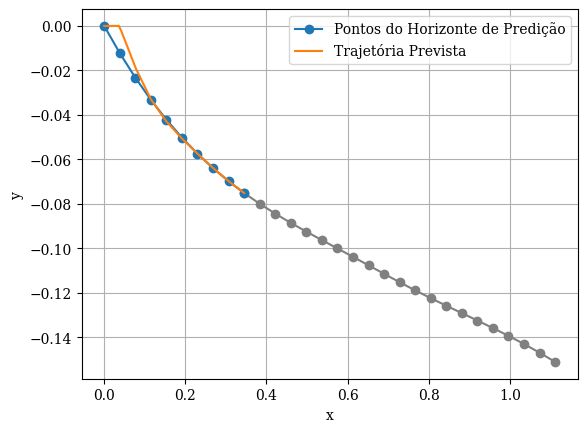

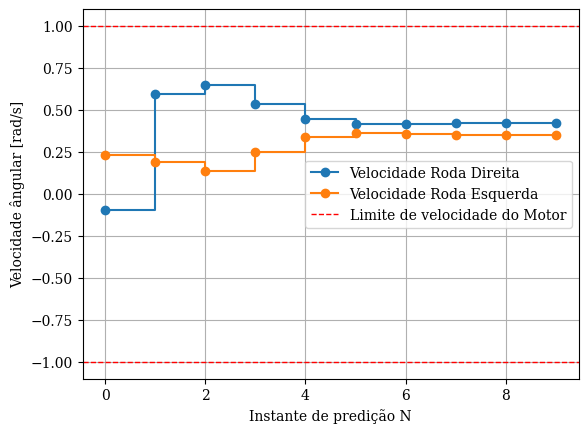

<Figure size 640x480 with 0 Axes>

In [73]:

# # Trajetória interpolada
x_ref = [0] + x_smooth
y_ref = [0] + y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []

v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon], disable_constrain=False)
v_out.append((v_R, v_L))
robot.update(v_R, v_L, dt)
x_traj.append(robot.x)
y_traj.append(robot.y)

# Plotar trajetória 
plt.plot(x_ref[predict_horizon - 1:], y_ref[predict_horizon - 1:], 'o-',color='grey')
plt.plot(x_ref[0:predict_horizon], y_ref[0:predict_horizon], 'o-', label='Pontos do Horizonte de Predição')
plt.plot([0] + out_x, [0] + out_y, '-', label='Trajetória Prevista')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_predicted_constrained')
plt.show()
plt.clf() 

# Plotar Velocidade
plt.step(range(len(out_v_R)), out_v_R, 'o-', where='post', label='Velocidade Roda Direita')
plt.step(range(len(out_v_L)), out_v_L, 'o-', where='post', label='Velocidade Roda Esquerda')
# plt.plot(x_traj, y_traj, label='Trajetória do Robô')
# plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
plt.xlabel('Instante de predição N')
plt.ylabel('Velocidade ângular [rad/s]')
plt.axhline(1, color='red', linewidth=1, linestyle='--', label='Limite de velocidade do Motor')  # Linha horizontal
plt.axhline(-1, color='red', linewidth=1, linestyle='--')  # Linha horizontal
plt.legend()
plt.grid(True)
plt.savefig(plt_path + 'trajectory_velocity_constrained')
plt.show()
plt.clf() 


out_X [0.042487264144500804, 0.043357599375276876, 0.07800160324149082, 0.11493910352604506, 0.1531581833298631, 0.1916255521900905, 0.2300319205226292, 0.26837822307185805, 0.30670116693549, 0.34502934039079985]
out_Y [-0.00243924738193917, -0.0028470071696961355, -0.019604573343134393, -0.0331103318555737, -0.04284266402338526, -0.05050513770595952, -0.05738190877787814, -0.06381843164605962, -0.0697511782385392, -0.07511927668561764]
out_v_R [-0.021363900543772806, 0.6348182505481865, 0.6462702343350794, 0.5262024760774476, 0.44084394845730657, 0.41735452801628625, 0.42060796515639237, 0.4238918865416533, 0.4231194431839126, 0.42311843084726286]
out_v_L [0.04058629850491854, 0.13486298939177074, 0.14031337603768043, 0.26257286591129786, 0.3436181525708498, 0.36298875769021316, 0.357046905758875, 0.35169705312756694, 0.35092586817691596, 0.35092573000888355]


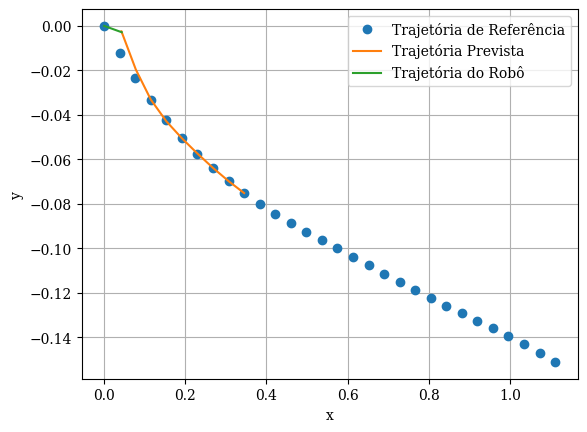

out_X [0.043357599375276876, 0.07834149757281864, 0.11511911299815654, 0.15324362922074097, 0.19164697949965911, 0.23002975553885102, 0.26837275446723885, 0.3066997578892166, 0.3450289752985427, 0.38336980220434874]
out_Y [-0.0028470071696961355, -0.019768982799186596, -0.03276653428061582, -0.0425171898041789, -0.05038761427300545, -0.05739304003096906, -0.06385118229355, -0.06976392756620987, -0.07511524800244754, -0.07992001771716624]
out_v_R [0.6656664988978115, 0.6133631565767694, 0.5141383249945186, 0.44605114948366215, 0.42432617021593155, 0.4233314988520328, 0.42366990402952115, 0.4221361637979428, 0.4215334937662462, 0.42153323674916376]
out_v_L [0.11156612838980684, 0.166772560048602, 0.272895097509328, 0.33797969020691637, 0.35601054852158953, 0.3543299103245026, 0.35193817946822553, 0.3518833547214909, 0.3512807969484351, 0.35128059611032786]


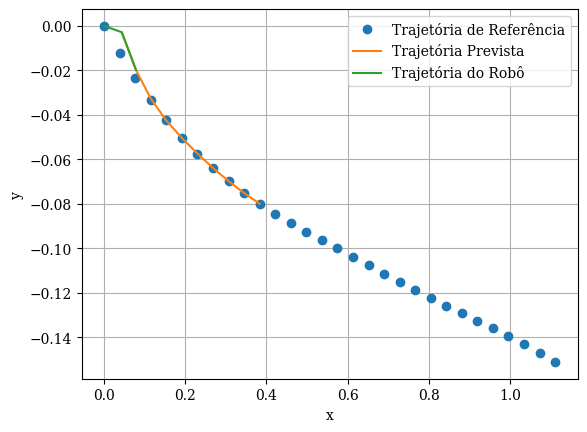

out_X [0.07834149757281864, 0.11510862270058848, 0.1532197194229751, 0.19163339132730658, 0.23002540313295985, 0.26837337399637534, 0.3067021909845764, 0.3450309948275521, 0.38336490159062997, 0.4217077749562564]
out_Y [-0.019768982799186596, -0.03276282691185036, -0.04259036093137772, -0.05045298086710541, -0.05741784670219924, -0.06384796559343886, -0.06974765575063449, -0.07510157604300509, -0.07995416466167084, -0.08435049707850417]
out_v_R [0.6083096557801158, 0.5197614178996159, 0.4481797724854852, 0.4235114837959192, 0.4223538537288043, 0.42264832393547797, 0.41918013980305885, 0.4157926721586787, 0.41533526750284744, 0.41533501250224086]
out_v_L [0.17160353810373993, 0.2673945052282166, 0.33602198253099697, 0.35686174142039334, 0.3553127324884072, 0.35295584203216906, 0.35483837845867455, 0.3570038143815128, 0.35654650495980594, 0.35654629776924707]


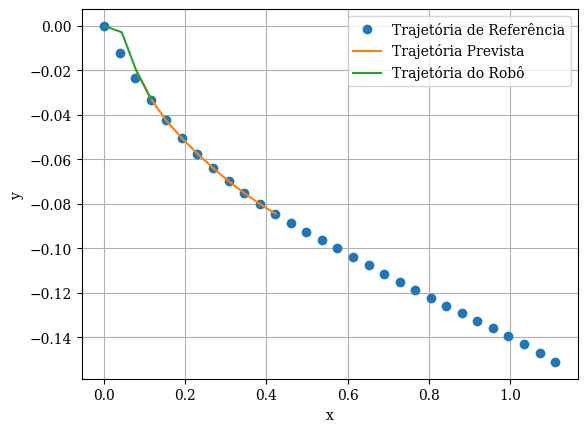

out_X [0.11510862270058848, 0.15321115486917655, 0.19160265174120641, 0.23000489075183111, 0.2683666410618011, 0.30670313957247186, 0.3450340713694464, 0.3833670850122504, 0.4217027425643292, 0.4600446448014325]
out_Y [-0.03276282691185036, -0.04258815242910263, -0.0505812834568838, -0.05752988612246168, -0.06388932249705832, -0.06974258480499493, -0.0750791000983417, -0.07993693439106393, -0.0843906123651157, -0.08849008913659445]
out_v_R [0.5112381916642641, 0.45780328027206824, 0.4270693215950522, 0.4207787634786023, 0.4207529746541861, 0.41770066722896027, 0.4123905872837921, 0.40879260547308166, 0.40846138483624556, 0.4084600703988081]
out_v_L [0.2757408370723996, 0.32649186205660474, 0.35344718432464634, 0.356927175253212, 0.35486234177618825, 0.3563119238569595, 0.3604013611470711, 0.3630773025779746, 0.36274732265693926, 0.36274694924369605]


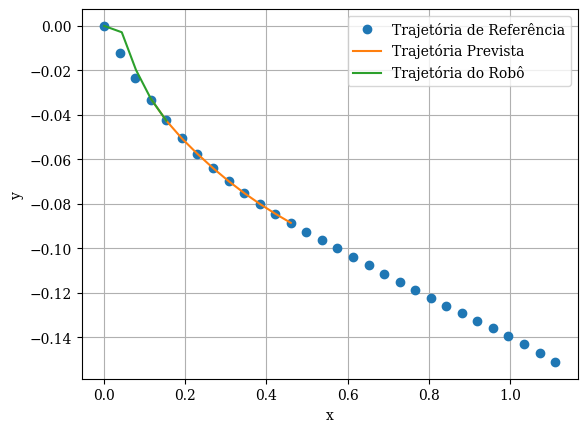

out_X [0.15321115486917655, 0.19159810085862633, 0.22999011617184675, 0.2683558403395862, 0.3066995256963737, 0.34503463607682916, 0.3833691766764157, 0.4217044200579531, 0.46004043941722966, 0.4983812640886023]
out_Y [-0.04258815242910263, -0.05058033596060407, -0.05760321880192787, -0.06395378603564635, -0.06976728003245014, -0.0750759162977005, -0.07992001783146464, -0.08437611836162266, -0.08852673739770973, -0.09241901688898548]
out_v_R [0.45295821397064784, 0.43250455480812755, 0.4228033392758664, 0.4199810067544497, 0.4167766604697461, 0.4113356277327716, 0.40561275024683197, 0.40229568450011105, 0.4020739624474833, 0.4020738581207928]
out_v_L [0.33124395894094005, 0.3480766961103171, 0.35495201945978316, 0.3556567744788251, 0.35724202325266474, 0.3614521368315393, 0.3662545225550619, 0.3689054614268238, 0.3686837624230711, 0.36868366963230503]


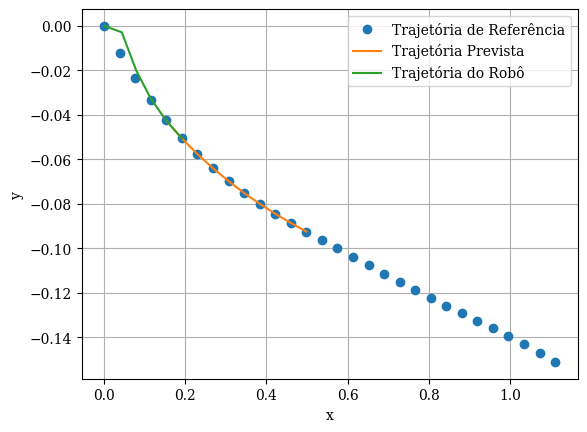

out_X [0.19159810085862639, 0.229987827206284, 0.26835097735502644, 0.30669581214062724, 0.34503326867098916, 0.3833694410568427, 0.421705782759457, 0.46004172469486804, 0.4983777211132391, 0.5367179273709424]
out_Y [-0.05058033596060407, -0.05760280009150477, -0.0639804289130336, -0.06979157579480641, -0.07508642573861098, -0.07991838527012762, -0.0843640287539172, -0.08851471638081279, -0.09245229641228549, -0.09622104317757886]
out_v_R [0.4307379776464081, 0.42472623634282913, 0.42073108559617894, 0.41667071951429485, 0.4112250534805532, 0.40492556612799807, 0.39934462489915284, 0.3963035453046102, 0.39617660300751434, 0.3961759777542933]
out_v_L [0.3497967343345068, 0.3530669080651542, 0.35492238930522574, 0.35735667254485876, 0.3615646840579284, 0.3669394068107954, 0.3718551292115785, 0.3744501528100004, 0.3743232005133236, 0.37432255396685366]


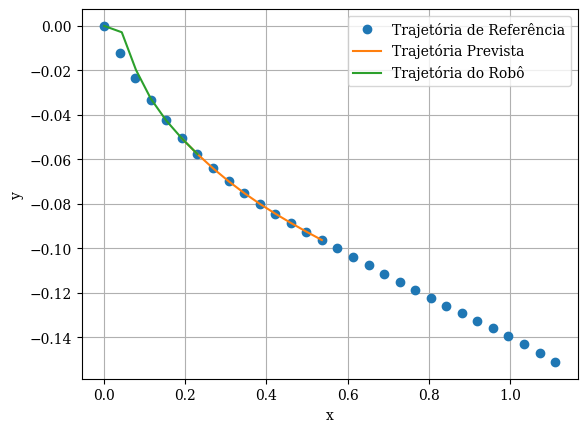

out_X [0.22998782720628402, 0.2683496997967838, 0.3066946220322253, 0.3450322619402122, 0.38336892377533144, 0.42170592612488467, 0.4600427747173564, 0.4983788026593955, 0.53671476211955, 0.5750546749359018]
out_Y [-0.05760280009150478, -0.06398021652713108, -0.06979857418688906, -0.07509380100361729, -0.07992288033044032, -0.08436303960504325, -0.0885047249625545, -0.09244139573518663, -0.09625268316041263, -0.09998128929881654]
out_v_R [0.42425457195223804, 0.4211789795235359, 0.41688439471041616, 0.4113952827349479, 0.405154584353721, 0.398816253734137, 0.3934697338945795, 0.3906145705584432, 0.3905729914447821, 0.39057236204134405]
out_v_L [0.35351267061924835, 0.3544978467640393, 0.35714766166840295, 0.361396965622922, 0.3667108867054449, 0.37238216887905473, 0.3772827335409512, 0.37988441050987587, 0.37984284912461874, 0.37984222478524315]


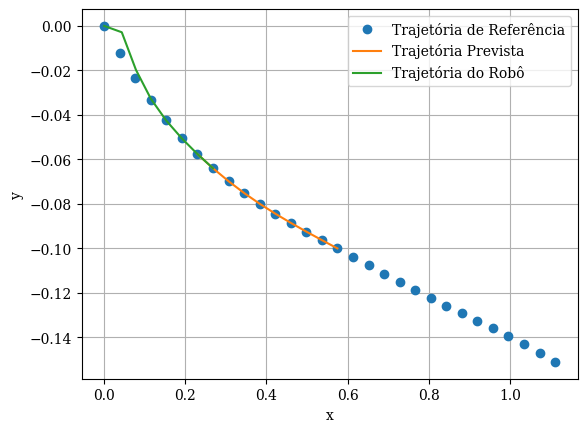

out_X [0.2683496997967838, 0.30669371197368306, 0.34503174820456156, 0.3833684460840446, 0.42170561712367843, 0.46004286842786746, 0.49837959837642193, 0.5367155949500062, 0.5750521937408682, 0.6133912515446359]
out_Y [-0.06398021652713108, -0.0697984360969991, -0.07509704780108761, -0.07992677753570065, -0.08436595534366167, -0.08850399496962129, -0.09243349048571688, -0.0962439117339515, -0.10000695042019454, -0.10375714670996868]
out_v_R [0.4209566856507316, 0.4170645823075035, 0.41150232592555763, 0.40532852335977226, 0.39904622694724007, 0.39305787742849424, 0.38831291590035655, 0.38605346789144307, 0.38606541509923653, 0.3860650803885275]
out_v_L [0.35470173112443465, 0.35698459133222143, 0.361292263499644, 0.3665380409977798, 0.3721523751019473, 0.3776939109338572, 0.3821850901655408, 0.3843633717494382, 0.3843753225287379, 0.38437498942364035]


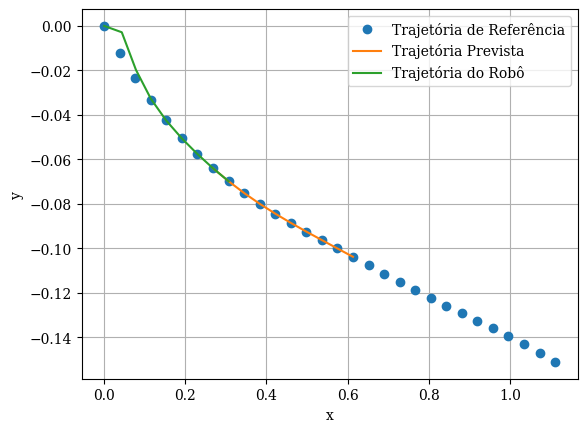

out_X [0.30669371197368306, 0.34503100404178916, 0.3833678009040146, 0.42170509599224487, 0.4600426191947695, 0.498379653218715, 0.5367160391892036, 0.5750526411408936, 0.6133899352872444, 0.651727585848757]
out_Y [-0.06979843609699911, -0.07509694495206448, -0.079931346133416, -0.0843704827270428, -0.08850642266262145, -0.09243301106654923, -0.09623940474399227, -0.1000021233099612, -0.10377102590726905, -0.10756453793105021]
out_v_R [0.41675800230093396, 0.4118117937660377, 0.4054633689534857, 0.3990990582230589, 0.39313090078259844, 0.3880709264157391, 0.3848131157364539, 0.38363401443361633, 0.3836617209887505, 0.38366136840016535]
out_v_L [0.3572761466104635, 0.3609964433634048, 0.3664055650965691, 0.372100445006767, 0.3776210111182416, 0.3824268664703814, 0.3856031614043681, 0.3868081311559315, 0.38683582840361513, 0.38683547048435946]


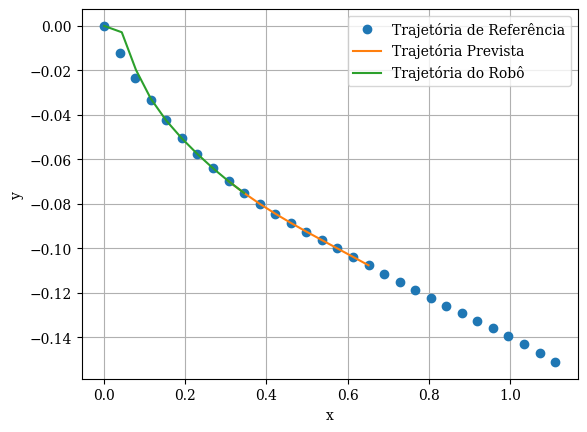

out_X [0.34503100404178916, 0.38336719287641124, 0.42170431287303456, 0.4600420351874161, 0.4983794500873235, 0.5367160638317224, 0.5750527502209396, 0.6133900056626094, 0.6517274163724894, 0.6900639245402901]
out_Y [-0.07509694495206448, -0.079931269459056, -0.08437664129594691, -0.08851180852737366, -0.09243502904947161, -0.09623917052669881, -0.10000100521863396, -0.10377014938863119, -0.10756659618545142, -0.11139274049328945]
out_v_R [0.4114031416295751, 0.4059225233665287, 0.3992688766384339, 0.39305829669478337, 0.3879816952504654, 0.38473962035030124, 0.38345866021956426, 0.38332582709604685, 0.3833462310738195, 0.3833458581451217]
out_v_L [0.3613928386401733, 0.36595728603483546, 0.37193292841300485, 0.37769433300495214, 0.38251618164887624, 0.385676610931111, 0.3869831877024815, 0.3871727305194338, 0.3871931225641145, 0.3871927428028012]


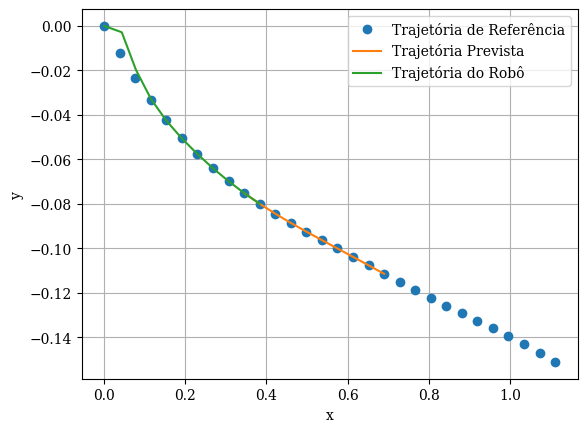

out_X [0.38336719287641124, 0.42170384197248, 0.4600412336314029, 0.49837889872274466, 0.5367159592839792, 0.5750527367777885, 0.6133896589116681, 0.6517270064354064, 0.6900652206469368, 0.728400123344199]
out_Y [-0.079931269459056, -0.08437658669278257, -0.08851870880976154, -0.09244037320905732, -0.09624022294575842, -0.10000114013911128, -0.10377367355106501, -0.10757104280800954, -0.11137899487366552, -0.11517833784143432]
out_v_R [0.4054671768693929, 0.39982573559269824, 0.3932371321616661, 0.3877617383062154, 0.38445877721729504, 0.3836197023914274, 0.3845717305497389, 0.38580335520202363, 0.3857619005210555, 0.38576150344017013]
out_v_L [0.36640315141731516, 0.3713844237910113, 0.37751730767415914, 0.3827365603284442, 0.38595747566035443, 0.38682214669089116, 0.3859273877961413, 0.3847339035631815, 0.38469245161021376, 0.3846920557778681]


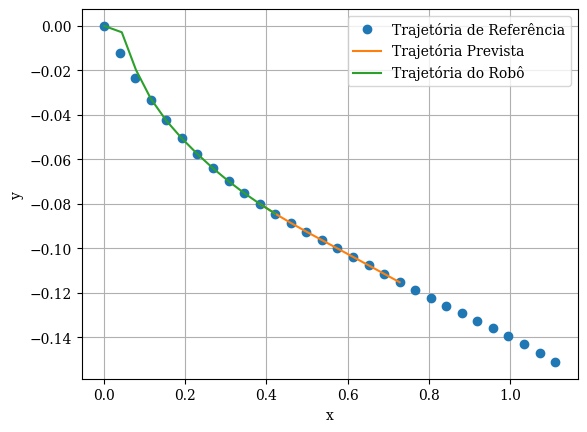

out_X [0.42170384197248, 0.46004089360813183, 0.49837812891037747, 0.5367154551329294, 0.5750527100718378, 0.6133896188293274, 0.6517263345326562, 0.6900644997300719, 0.7284023700359754, 0.7667365787525822]
out_Y [-0.08437658669278258, -0.08851867207231409, -0.09244751800952357, -0.09624529755738108, -0.10000142716111621, -0.1037740775061617, -0.10757786459455244, -0.11138720575186192, -0.1151534350140595, -0.11884248693795565]
out_v_R [0.39935602331310616, 0.3938418496277785, 0.38793920984128855, 0.384138965096168, 0.3832088354598651, 0.3849002494245596, 0.3880517579283669, 0.39018699929473494, 0.39007584903717357, 0.39007542462952144]
out_v_L [0.37184729602777067, 0.37691866856657663, 0.3825602934391444, 0.3862774485012874, 0.3872329764133105, 0.3855989568389272, 0.3824872717793076, 0.38026138507574364, 0.38015026374414707, 0.3801498537710371]


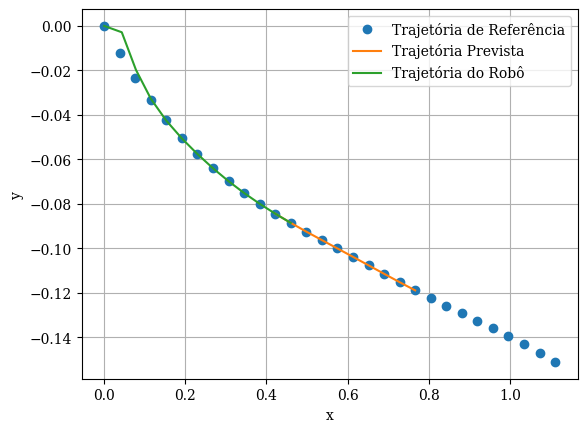

out_X [0.4600408936081319, 0.4983779089590651, 0.5367147244572228, 0.5750522005144448, 0.6133895691151817, 0.6517262998162701, 0.6900639241547021, 0.7284017963450441, 0.7667384083209341, 0.8050736649237229]
out_Y [-0.0885186720723141, -0.0924474954686488, -0.09625246782328405, -0.10000665241659204, -0.10377460105557229, -0.107578193438438, -0.11139312078966349, -0.11516061741038353, -0.1188206170170946, -0.12234354718473454]
out_v_R [0.3933718848109396, 0.3885360074328401, 0.38431882726090305, 0.3829148930929771, 0.38452335717496616, 0.388334241272773, 0.3921623500101221, 0.3939619769527009, 0.3938205350511002, 0.3938189687702482]
out_v_L [0.3773842113173431, 0.38196752589048016, 0.38609819549977925, 0.38752686802194775, 0.3859757631003885, 0.38220507910207796, 0.37828855040305254, 0.37625654136813197, 0.3761152897431521, 0.3761138451490162]


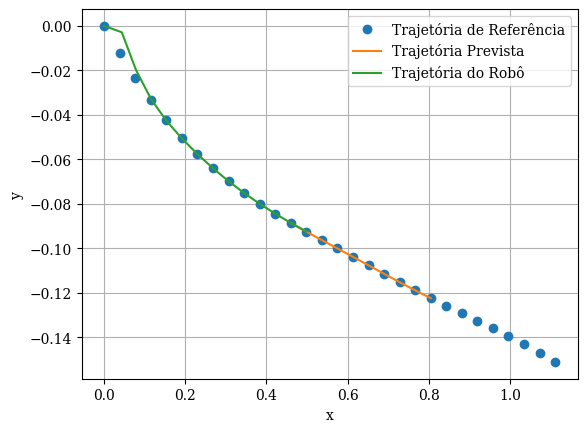

out_X [0.4983779089590651, 0.536714610897324, 0.5750515418948197, 0.6133890125715448, 0.6517261076733528, 0.6900639408537272, 0.7284018253890023, 0.7667384709726844, 0.8050735962785541, 0.8434114093068356]
out_Y [-0.0924474954686488, -0.09625245655233551, -0.10001331989706254, -0.10378028665871043, -0.10758013332204114, -0.1113929480346926, -0.11516036693076301, -0.1188207648240611, -0.12234253853086025, -0.12572454261845945]
out_v_R [0.3881000329498593, 0.3848188148597765, 0.3830951026947067, 0.38441682539520955, 0.38820156988887156, 0.3921317675677116, 0.3940622269945564, 0.3940225533017982, 0.39392386070669283, 0.393922350453713]
out_v_L [0.3824012180163607, 0.3856003882769039, 0.387346769602491, 0.38608215461965956, 0.3823377241121975, 0.3783192265332964, 0.3761577175264, 0.37590854030550735, 0.3758100827881478, 0.3758087224363296]


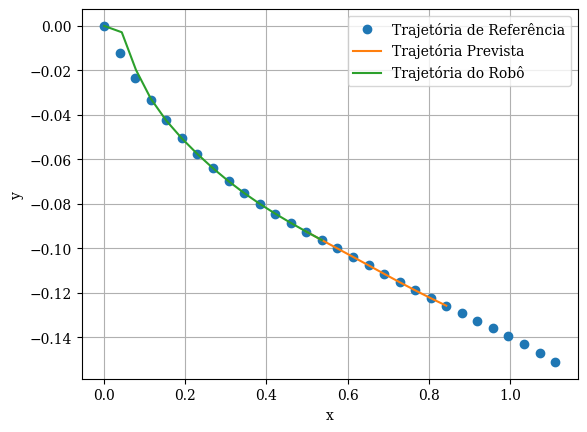

out_X [0.536714610897324, 0.5750515129258512, 0.6133885363138963, 0.6517256248081491, 0.6900636747139012, 0.7284018847266721, 0.7667389705767088, 0.8050741356334202, 0.8434098744967657, 0.8817489635634581]
out_Y [-0.09625245655233551, -0.10001331705519889, -0.10378514156277083, -0.10758501547901472, -0.11139566369928959, -0.11515980996216776, -0.11881542180997541, -0.1223367906889722, -0.12574114710420503, -0.12905082655370756]
out_v_R [0.3845019392383937, 0.3834101869346455, 0.3845598732057971, 0.3882737304263027, 0.3922303791972632, 0.3937764759742784, 0.39253798474665635, 0.3910119477036857, 0.39096273607056337, 0.3909616485124384]
out_v_L [0.38591668173773375, 0.3870322891455243, 0.3859390290635065, 0.3822655899031747, 0.37822069493307015, 0.376443141915282, 0.3773931598909062, 0.3787200879555633, 0.37867087247869574, 0.3786697646910404]


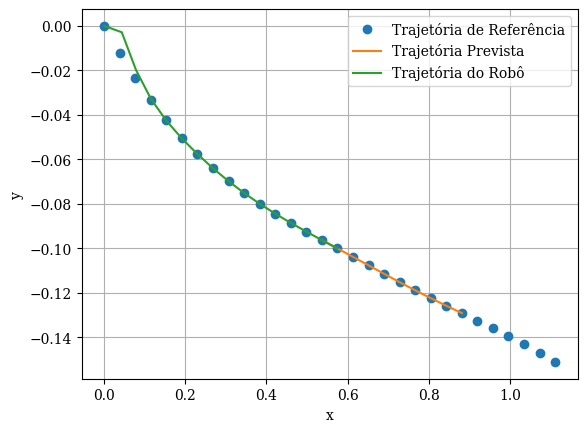

out_X [0.5750515129258512, 0.6133885486434696, 0.6517254348284167, 0.690063414687038, 0.7284016679219071, 0.7667390368974322, 0.8050747639594752, 0.8434105412409527, 0.881746982518204, 0.9200860620282741]
out_Y [-0.10001331705519889, -0.10378514277582762, -0.10758693567334786, -0.11139829490426582, -0.11516211237037097, -0.11881479422049761, -0.1223298145152703, -0.12573335831867757, -0.12907372613080242, -0.13238168247532212]
out_v_R [0.383285094613726, 0.3846386088973433, 0.38834160715995614, 0.39240006929162907, 0.3939993160401677, 0.3921766857268478, 0.38895770634720406, 0.3869295232016043, 0.3869278561534937, 0.3869268280964888]
out_v_L [0.38715762924853275, 0.3858600534228984, 0.3821977257302274, 0.3780512226195211, 0.3762203785051523, 0.377754048053294, 0.38077365723262174, 0.38270436038821687, 0.382702598767597, 0.3827015010281841]


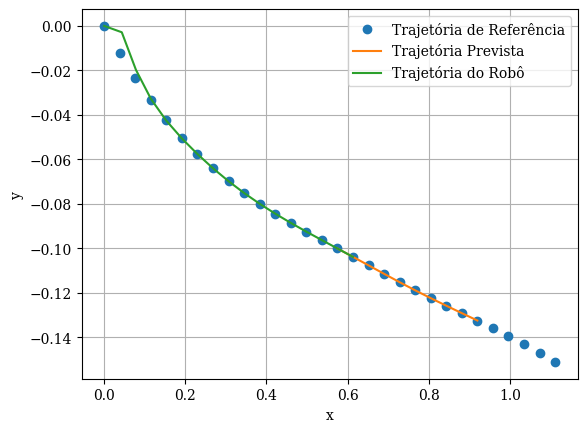

out_X [0.6133885486434696, 0.6517254568790857, 0.690063569085335, 0.7284017075119775, 0.7667389303213968, 0.805074815876005, 0.8434111140223393, 0.8817475915613897, 0.920084192856261, 0.9584229018971216]
out_Y [-0.10378514277582761, -0.10758693786006893, -0.11139676034591435, -0.11516175349863893, -0.1188160125723687, -0.12232930148717988, -0.12572682341059835, -0.12906621630726922, -0.1324040525926173, -0.13577052214508048]
out_v_R [0.3847389097656073, 0.38816466343330863, 0.39237391078299855, 0.39421509103700236, 0.39245640333251214, 0.38862824844427696, 0.38491789993855813, 0.3829752559850271, 0.3830215531809346, 0.3830205264719089]
out_v_L [0.3857601957312441, 0.38237426352953074, 0.3780773937029739, 0.37600468594, 0.37747432608525555, 0.38110285026074936, 0.38471501386044155, 0.3866574226082474, 0.3867030022393076, 0.38670149552247757]


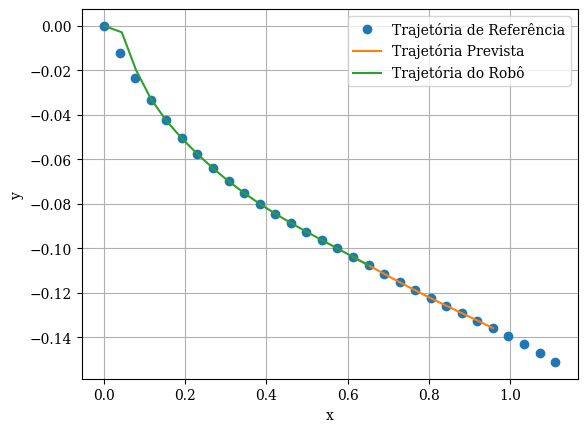

out_X [0.6517254568790858, 0.6900635987413215, 0.7284021615882635, 0.7667392234944072, 0.8050748046515916, 0.8434111499331144, 0.8817480915159285, 0.9200847204868124, 0.9584212228817002, 0.9967597014543221]
out_Y [-0.10758693786006894, -0.1113967632929568, -0.11515724080388663, -0.11881301913910548, -0.12232948685390702, -0.1257264416138342, -0.12906044687335902, -0.13239721792831347, -0.13579114535000386, -0.13927024527687012]
out_v_R [0.3884593023130471, 0.3919802117605446, 0.39410672573053446, 0.3927006193694596, 0.38894255841478986, 0.38463564125054056, 0.3811162008525774, 0.37936601821563015, 0.37946256537554496, 0.37946152670846606]
out_v_L [0.38208022069092984, 0.37847071913100305, 0.3761127315234612, 0.37722985225681344, 0.3807884780344472, 0.3849971753557348, 0.3885151815310332, 0.3903628065441244, 0.3904577097279025, 0.39045554085522677]


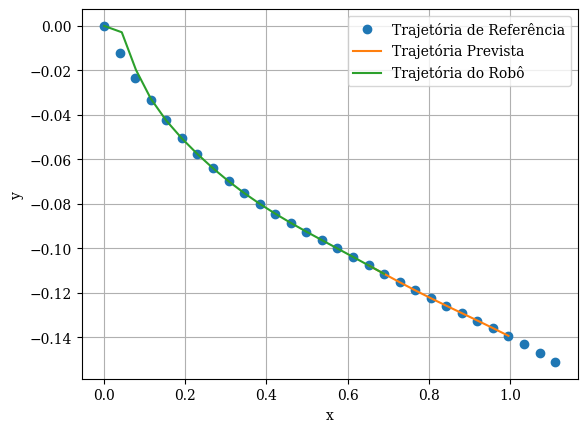

out_X [0.6900635987413215, 0.728402155051039, 0.7667396914196886, 0.8050751081982418, 0.8434111476042127, 0.8817481224931911, 0.9200852021847897, 0.9584217096246056, 0.996758109151657, 1.0350965451050107]
out_Y [-0.11139676329295681, -0.1151572401626762, -0.1188082675202469, -0.12232625394294545, -0.1257264966003205, -0.1290600923940328, -0.1323916979761579, -0.1357845713658268, -0.1392900999015826, -0.14293536723776498]
out_v_R [0.3922900941012328, 0.39369780470528454, 0.39258506448529623, 0.3891835985165423, 0.38494578554540937, 0.3808475897468405, 0.3775754251240673, 0.37594183981681467, 0.37609218692414004, 0.3760911507181198]
out_v_L [0.378160705418393, 0.3765220848283973, 0.37734490844876384, 0.380547151152477, 0.38468698521060335, 0.38878382204302686, 0.39215164144220166, 0.39398497722653386, 0.3941347004776865, 0.3941332790755643]


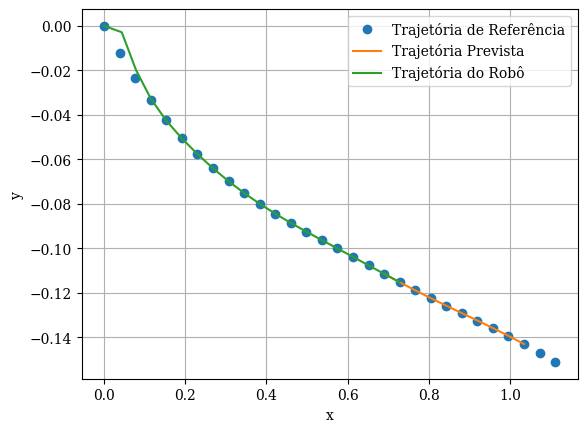

out_X [0.728402155051039, 0.7667396128500191, 0.8050752820404984, 0.843411216432887, 0.8817480410071307, 0.9200852383156635, 0.958422224940237, 0.9967585919100811, 1.0350949501858724, 1.0734334259511273]
out_Y [-0.11515724016267621, -0.11880826003776268, -0.12232439959356856, -0.12572575612275141, -0.1290610277423288, -0.13239125779492075, -0.13577880259568276, -0.1392834225227693, -0.1429552652347322, -0.14682147433958037]
out_v_R [0.3938179486313203, 0.39239228318230707, 0.38914690265270274, 0.3851447375098087, 0.3811054132795328, 0.3772865418639477, 0.3741519542803517, 0.3725780896397671, 0.3727897588029318, 0.37278871534003366]
out_v_L [0.376400362399225, 0.3775393422644609, 0.38058372346947816, 0.3844879424648455, 0.3885259607369374, 0.3924406833864072, 0.395772559750267, 0.39765792477136414, 0.39786873797745875, 0.3978671691409795]


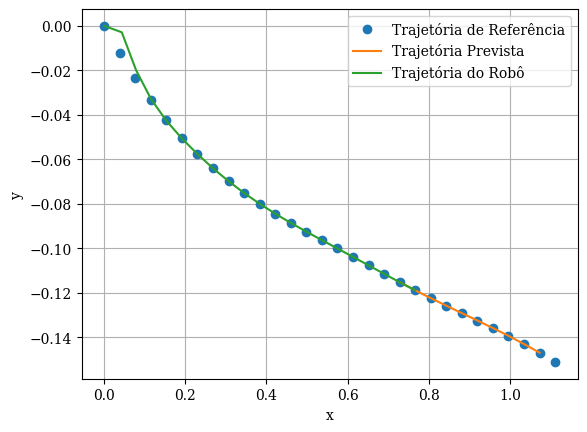

<Figure size 640x480 with 0 Axes>

In [74]:

# theta_ref = np.arctan2(np.gradient(y_ref), np.gradient(x_ref))
# x_margin_sup = x_ref + margin * np.cos(theta_ref + np.pi/2)
# y_margin_sup = y_ref + margin * np.sin(theta_ref + np.pi/2)
# x_margin_inf = x_ref - margin * np.cos(theta_ref + np.pi/2)
# y_margin_inf = y_ref - margin * np.sin(theta_ref + np.pi/2)

# print('iniciando simulação')
# print('len xref', len(x_ref))

# # Trajetória interpolada
x_ref = [0] + x_smooth
y_ref = [0] + y_smooth

# # # Simulação
dt = delta_time
x_traj = [0]
y_traj = [0]
v_out = []
robot_out = DifferentialDriveRobot(R, L)

for i in range(len(x_ref) - predict_horizon):  # Garantir que o loop seja executado
    v_R, v_L, [out_x, out_y], [out_v_R, out_v_L] = mpc.solve(x_ref[i:i+predict_horizon], y_ref[i:i+predict_horizon])
    v_out.append((v_R, v_L))
    robot.update(v_R, v_L, dt)
    x_traj.append(robot.x)
    y_traj.append(robot.y)

    # Plotar trajetória com margem
    plt.plot(x_ref, y_ref, 'o', label='Trajetória de Referência')
    plt.plot(out_x, out_y, label='Trajetória Prevista')
    plt.plot(x_traj, y_traj, label='Trajetória do Robô')
    # plt.fill_between(x_ref, y_margin_inf, y_margin_sup, color='gray', alpha=0.3, label=f'Margem de {margin} m')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.savefig(plt_path + f'simulation/trajectory_out_{i}')
    plt.show()
    plt.clf() 

# # v_R, v_L, out_x, out_y = mpc.solve(x_ref[0:predict_horizon], y_ref[0:predict_horizon])
# # v_out.append((v_R, v_L))
# # robot.update(v_R, v_L, dt)
# # x_traj.append(robot.x)
# # y_traj.append(robot.y)

# print('v_out', v_out)
# print('v_out.len', len(v_out))




